# Predicting house prices

Now, it's our turn to design a regression model. In this module, we'll be using a version of the houseprices dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa.

Using this data, our task will be to predict the prices of the houses. We can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

## Preliminary data exploration

To choose the features that we'll use in our model, we will do a brief exploratory analysis here. First, import the relevant libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

Next, load the data from the PostgreSQL database and print out some observations:

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM houseprices""")
    house_price_df = pd.read_sql_query(query, conn)

# No need for an open connection, because you're only doing a single query
engine.dispose()


house_price_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
house_price_df.shape

(1460, 81)

In [4]:
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
house_price_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We can see that there are 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. Some of the columns are numerical while other columns are non-numerical. There are also a lot of null values in multiple columns.

Let's first classify which columns are numerical and which are non-numerical.

In [6]:
# Numerical
numeric_columns = house_price_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [7]:
# Non-Numerical
non_numeric_columns = house_price_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numeric columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 43


## Data Cleaning
We now need to address the columns with missing values. These are

In [8]:
# Missing values
columns_missing_values = house_price_df.columns[house_price_df.isnull().any()]
columns_missing_values
print("The number of columns with missing values is {}".format(len(columns_missing_values)))

The number of columns with missing values is 19


We will summarize how much values are missing from these columns:

In [9]:
missing_mask = house_price_df.isna()
total_missing = missing_mask.sum().sort_values(ascending=False)
percent_missing = (missing_mask.sum() / missing_mask.count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total Missing', 'Percent Missing'])
missing_data.head(19)

,Total Missing,Percent Missing
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


We will fix the `bsmtqual` column as we will use it as a feature in our regression model. As `bsmtqual` is a categorical column, we will replace the missing values with the most common category in the `bsmtqual` column.

In [10]:
house_price_df['bsmtqual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: bsmtqual, dtype: int64

In [11]:
bsmtqual_list = house_price_df['bsmtqual']

for i in range(0, len(bsmtqual_list)):
    if pd.isnull(bsmtqual_list[i]):
        bsmtqual_list[i] = 'TA'

bsmtqual_list.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

## Exploratory data analysis and feature selection

We will now look at the distribution of our target variable: `saleprice`. Investigating how our target is distributed will help us understand the relationship between the target variable and the feature variables. It's also useful for discovering some potential problems with our model.

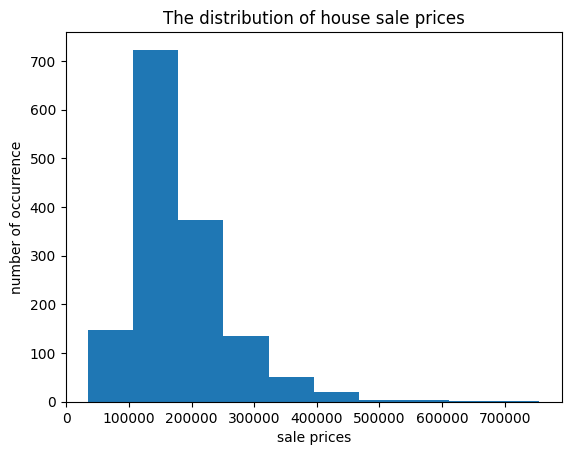

In [12]:
plt.hist(house_price_df.saleprice)
plt.title("The distribution of house sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

We can see that sale prices is not normally distributed. Instead, it's highly right skewed. The majority of the observations have low sale prices below \$400,00; few of the observations have high sale prices above \$500,000.

We will now look at the correlation (irrespective of sign) of the top ten features and the target variable through the `heatmap` function in Seaborn.

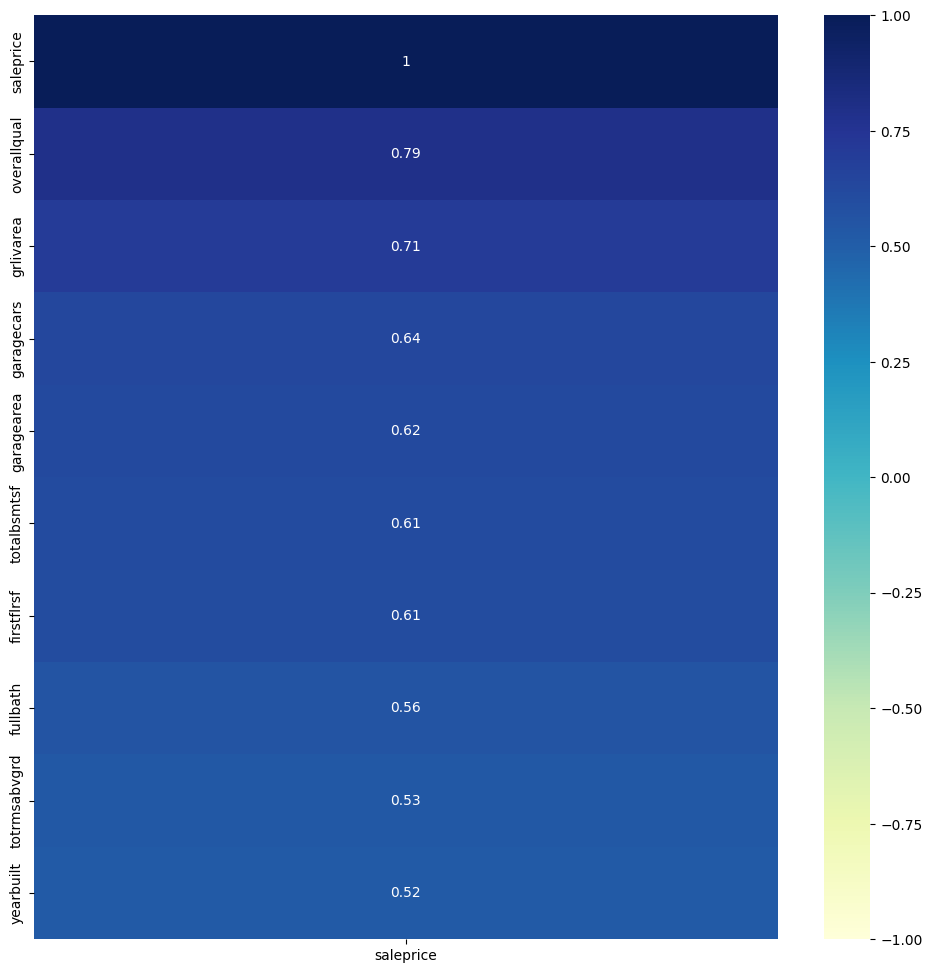

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
corr_matrix = np.abs(house_price_df.corr())
sns.heatmap(house_price_df.corr()[['saleprice']].sort_values('saleprice').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

From here we can see that the top five numerical variables correlated with `saleprice` are:

*   `overallqual`
*   `grlivarea`
*   `garagecars`
*   `garagearea`
*   `totalbsmtsf`


Next, to understand the univariate relation between our target variable and non-numerical features; we plot each feature against the target variable. In the charts below, we show the average sale prices with respect to the every category of a feature.

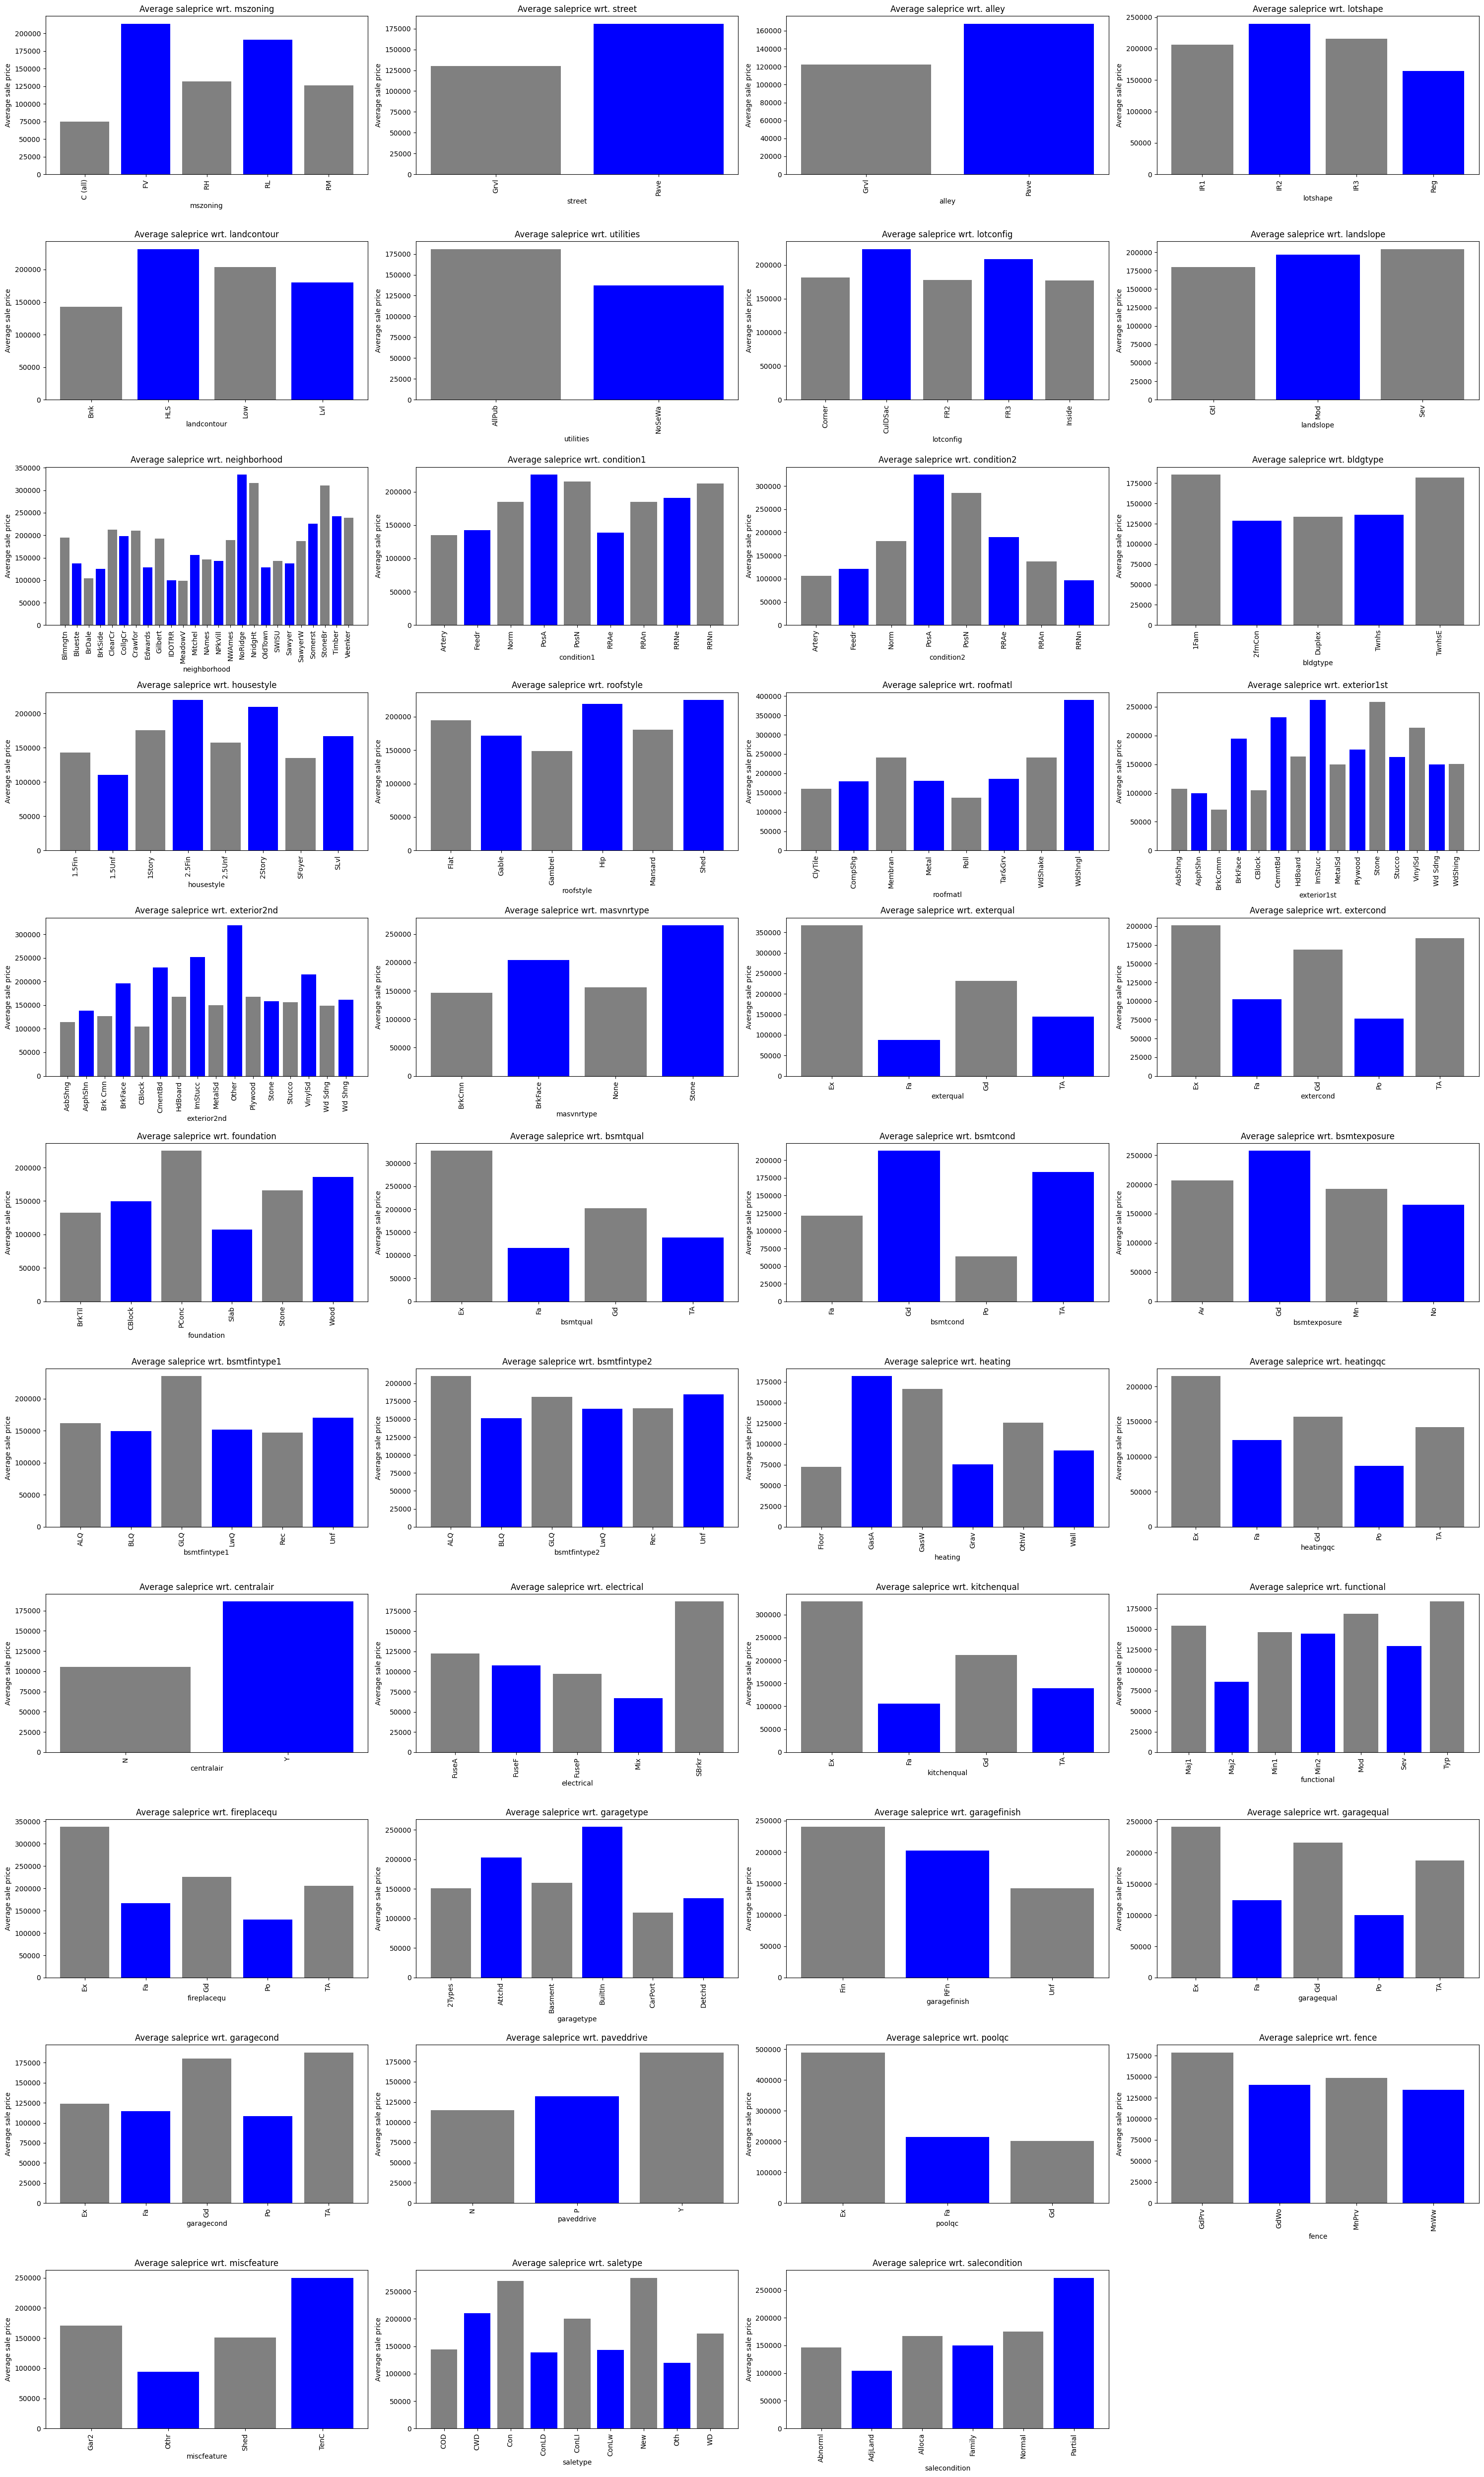

In [14]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_price_df.groupby(column)["saleprice"].mean().index,
            house_price_df.groupby(column)["saleprice"].mean(),
           color=("grey","blue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

From these we see that `mszoning`, `street`, `utilities`, `bsmtqual`, and `salecondition` exhibit some variance with respect to the average sale price. We will add these five non-numerical features by converting them to dummy variables.

In [21]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

## Regression Model

We will now create our model and use linear regression with the five numerical variables and five non-numerical variables.

In [22]:
X = house_price_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_price_df['saleprice']

# Manually add a constant for the intercept/bias term
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     300.9
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:38:18   Log-Likelihood:                -17374.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1440   BIC:                         3.489e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.277e+04   1.87e+04     -1.756      0.079   -6.94e+04    3841.995
overallqual            1.785e+04   1139.300     15.667      0.000    1.56e+04    2.01e+04
grlivarea                47.5101      2.331     20.384      0.000      42.938      52.082
garagecars              1.13e+04   2888.606      3.910      0.000    5629.241     1.7e+04
garagearea               10.6077      9.898      1.072      0.284      -8.808      30.024
totalbsmtsf              21.1576      2.812      7.523      0.000      15.641      26.674
mszoning_FV            1.226e+04   6496.468      1.887      0.059    -485.866     2.5e+04
mszoning_FV            1.226e+04   6496.468      1.887      0.059    -485.866     2.5e+04
mszoning_RH            8415.7750   7446.004      1.130      0.259   -6190.401     2.3e+04
mszoning_RH            8415.7750   7446.004      1.130      0.259   -6190.401     2.3e+04
mszoning_RL            1.539e+04   6034.305      2.551      0.011    3556.358    2.72e+04
mszoning_RL            1.539e+04   6034.305      2.551      0.011    3556.358    2.72e+04
mszoning_RM            5429.7722   6115.597      0.888      0.375   -6566.661    1.74e+04
mszoning_RM            5429.7722   6115.597      0.888      0.375   -6566.661    1.74e+04
street_Pave            -546.8450   7673.822     -0.071      0.943   -1.56e+04    1.45e+04
street_Pave            -546.8450   7673.822     -0.071      0.943   -1.56e+04    1.45e+04
utilities_NoSeWa      -8938.6188   1.81e+04     -0.495      0.621   -4.43e+04    2.65e+04
utilities_NoSeWa      -8938.6188   1.81e+04     -0.495      0.621   -4.43e+04    2.65e+04
bsmtqual_Fa           -3.179e+04   3917.553     -8.114      0.000   -3.95e+04   -2.41e+04
bsmtqual_Fa           -3.179e+04   3917.553     -8.114      0.000   -3.95e+04   -2.41e+04
bsmtqual_Gd           -2.473e+04   2055.409    -12.031      0.000   -2.88e+04   -2.07e+04
bsmtqual_Gd           -2.473e+04   2055.409    -12.031      0.000   -2.88e+04   -2.07e+04
bsmtqual_TA           -2.899e+04   2417.472    -11.992      0.000   -3.37e+04   -2.42e+04
bsmtqual_TA           -2.899e+04   2417.472    -11.992      0.000   -3.37e+04   -2.42e+04
salecondition_AdjLand  2507.7232   9218.890      0.272      0.786   -1.56e+04    2.06e+04
salecondition_AdjLand  2507.7232   9218.890      0.272      0.786   -1.56e+04    2.06e+04
salecondition_Alloca   3924.9632   5567.592      0.705      0.481   -6996.497    1.48e+04
salecondition_Alloca   3924.9632   5567.592      0.705      0.481   -6996.497    1.48e+04
salecondition_Family  -3813.0003   4423.674     -0.862      0.389   -1.25e+04    4864.535
salecondition_Family  -3813.0003   4423.674     -0.862      0.389   -1.25e+04    4864.535
salecondition_Normal   4515.5401   1911.072      2.363      0.018     766.757    8264.323
salecondition_Normal   